In [16]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [17]:
 pip install tensorflow-object-detection-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 95.6 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filen

In [18]:
import os
import cv2
import glob

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import pathlib
import io
import scipy.misc
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
def convert_video_to_frames(video_file_path, frames_folder_path):
    if not os.path.exists(frames_folder_path):
        os.makedirs(frames_folder_path)
        
    cam = cv2.VideoCapture(video_file_path)

    # Setting the frame index to 0
    frame_idx = 0

    # Looping through the video frames
    while(cam.isOpened()):
        ret, frame = cam.read()
        if not ret:
            break
        frame_file_path = os.path.join(frames_folder_path, f"frame{frame_idx:04d}.jpg")
        cv2.imwrite(frame_file_path, frame)

        # Incrementing the frame index
        frame_idx += 1

    # Release the video capture object
    cam.release()
    print(f"Video converted to {frame_idx} frames and saved in {frames_folder_path}")

### STEP-1 COLLECT A SOURCE VIDEO AND DIVIDE THE VIDEO INTO DISCRETE IMAGE FRAMES

In [21]:
video_file_path = "/content/drive/My Drive/Traffic_dataset.mp4"
frames_folder_path = "/content/drive/My Drive/TrafficImage_Frames"
convert_video_to_frames(video_file_path, frames_folder_path)

Video converted to 255 frames and saved in /content/drive/My Drive/TrafficImage_Frames


In [22]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


In [23]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


Installing the object detection API

In [24]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696872 sha256=f14052301d3cf652994599a2e66df015fccd1e73c9b85fa20c6805c236e377c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-2lep1c_l/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


Importing the dependencies

In [25]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

Loading the label map data

In [26]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Build a detection model and load pre-trained model weights

In [27]:
model_display_name = 'Faster R-CNN Inception ResNet V2 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1


Loading the selected model from TensorFlow Hub


In [28]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


### STEP 2- LOADING THE IMAGES AND CONDUCTING INFERENCES BY DRAWNIG BOUNDING BOXES

In [29]:
results_1 = []
dir_path = '/content/drive/My Drive/TrafficImage_Frames/*.jpg'

for filename in glob.glob(dir_path):
    print("Processing: ", filename)
    image_np = load_image_into_numpy_array(filename)
    # running inference
    results = hub_model(image_np)
    result = {key:value.numpy() for key,value in results.items()}
    #Visualizing the results
    label_id_offset = 0
    image_np_with_detections = image_np.copy()

  # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in result:
     keypoints = result['detection_keypoints'][0]
     keypoint_scores = result['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints,
        keypoint_scores=keypoint_scores,
        keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)
    results_1.append(image_np_with_detections[0])

Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0000.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0001.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0002.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0003.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0004.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0005.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0006.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0007.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0008.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0009.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0010.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0011.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0012.jpg
Processing:  /content/drive/My Drive/TrafficImage_Frames/frame0013.jpg
Proces

VISUALISING AN IMAGE WITH BOUNDING BOXES

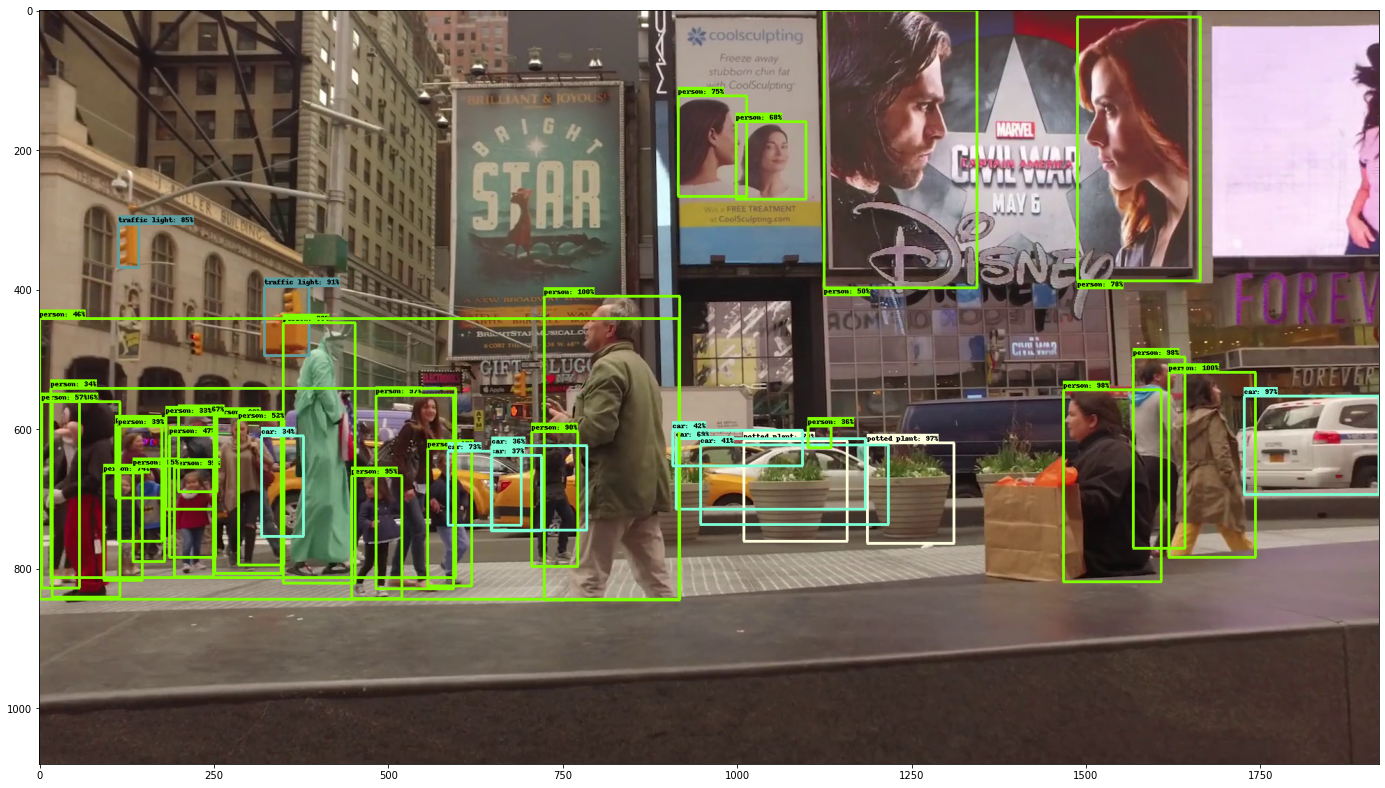

In [32]:
plt.figure(figsize=(24,32))
plt.imshow(results_1[10])
plt.show()

### STEP -3 CONVERTING THE IMGAGE FRAMES WITH BOUDING BOXES INTO VIDEO TO EXPORT

In [33]:
height, width, layers = results_1[0].shape
size = (width,height)

out = cv2.VideoWriter('/content/drive/My Drive/Output_video/objectdetectionvideo.mp4',cv2.VideoWriter_fourcc(*"mp4v"), 45, size)
 
for i in range(len(results_1)):
    out.write(results_1[i])
out.release()

REFERENCES:
1. https://www.geeksforgeeks.org/extract-images-from-video-in-python/
2. https://www.geeksforgeeks.orgsaving-operated-video-from-a-webcam-using-opencv/
